## Load modules

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

## Ensure results are reproducable...

In [3]:
random_seed = 1
np.random.seed(random_seed)

Record key data from business problem...

In [4]:
trial_N = 5_000 # number of observations in the original sample 
rollout_N = 50_000 # the sample of customers they plan to roll the new model out to

TP_profit = 100 - 10   # the loan profit minus the targeting cost
FP_profit = 0 - 10   # no loan profit, just the targeting cost
TN_profit = 0 - 0 # they wouldn't take a loan, and we didn't spend the money targeting them
FN_profit = -100 + 10 # they would have taken the loan, but we didn't target them 

# this will be useful for later calculations involving the confusion matrix
pl_matrix = np.array([[TN_profit, FP_profit],[FN_profit, TP_profit]]) 

## Load and clean data

In [5]:
bank_df = pd.read_csv('../../Data/UniversalBank.csv') # change this path depending on where you store the file on your computer
bank_df.columns = [s.strip().upper().replace(' ', '_') for s in bank_df.columns]
bank_df = bank_df.drop(columns=['ID', 'ZIP_CODE'])

# note: with knn changing these to categorical doesn't affect the results. You can try this by commenting 
# the following two lines and rerunning the analysis.
categorical_data = ['SECURITIES_ACCOUNT', 'CD_ACCOUNT','ONLINE', 'CREDITCARD', 'PERSONAL_LOAN', 'EDUCATION']
bank_df[categorical_data] = bank_df[categorical_data].astype('category')

## Record key measures about business and data

In [6]:
nonloan_N = len(bank_df[bank_df.PERSONAL_LOAN== 0]) # number that did not take loan 
loan_N    = len(bank_df[bank_df.PERSONAL_LOAN== 1]) # number that did take loan
loan_percent_of_trial = loan_N / trial_N # percent of customers contacted that took the loan
expected_best_possible = rollout_N * loan_percent_of_trial * TP_profit # if loan percent hold in the rollout, this is the best possible return from a model

print(f"Total customers targeted in trial: {trial_N}")
print(f"   Total that take loan: {loan_N}")
print(f"   Total that do not: {nonloan_N}")
print(f"   Percent that took loan: {loan_percent_of_trial*100}")
print(f"Expected best possible result from rollout with 'perfect model': ${expected_best_possible:,.2f}")

Total customers targeted in trial: 5000
   Total that take loan: 480
   Total that do not: 4520
   Percent that took loan: 9.6
Expected best possible result from rollout with 'perfect model': $432,000.00


## Create training and test partitions

In [7]:
test_part_size_percent = .3 # use 30% test split

In [8]:
cols = list(bank_df.columns)
cols.remove('PERSONAL_LOAN')

y = bank_df['PERSONAL_LOAN']
X = bank_df[cols]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_part_size_percent, random_state=random_seed)

In [9]:
(y_test==1).sum() / len(y_test)

0.09933333333333333

Note that the percentage of those that took the loan in the original data was 9.6%. With our datasplit, we find that this is now 9.9 percent. Do you understand why?

### Experiment to demonstrate expected value

This subsection is not essential to the analysis. To increase your conceptual understanding, I've included an experimental file that explores what a good percentage to use may be. In this linked notebook, I answer the following:

1) Why do we find 9.9 percent in our test set
2) what percent should be we when thinking about the percentage that take a loan in the 50,000 customers that they plan to market the loan to next?

In [10]:
# note: you may need to install fastparquet model
#  conda install fastparquet
bank_df.to_parquet("UniversalBankProcessed.parquet.gzip", compression="gzip")

This is a test [to sample notebook](c06_1a_expected_values.ipynb).

So, as can see from this notebook, our best value to use is the mean (9.6%) when identifying the expected percentage in the bigger population (even if our test set has a slightly different value).

## Rescale data (k-NN is particularly sensitive to distances in scale)

In [15]:
# create a standard scaler and fit it to the training set of predictors
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the predictors of both the training and validation sets
X_train = scaler.transform(X_train) # train_predictors is not a numpy array #NOTE: This will return a numpy array
X_test = scaler.transform(X_test) # train_predictors is not a numpy array #NOTE: This will return a numpy array

## Explore various models and record their score (Classification, Recall, Precision, F1 and our profit and loss custom score metric)

Calculate key scoring data for k-nn models with k from 1 to root N times 2 for each cutoff from 0.1, 0.2, 0.3, 0.4, and 0.5. 

In [16]:
start = 0.05
stop = 0.35
step = 0.05

results = []
for cut_off_threshold in np.round(np.arange(start, stop, step),3):
    for k in range(1,int(len(y_train)**0.5)*2,2): #  k values from 1 to root of n
        knn = KNeighborsClassifier(n_neighbors=k,  metric='euclidean')
        knn.fit(X_train, y_train)
        predictions = (knn.predict_proba(X_test)[:,1]>=cut_off_threshold).astype(int)

        confusion = confusion_matrix(y_test, predictions)
        
        TN FP
        FN TP
        
        
        TP = confusion[1,1]
        TN = confusion[0,0]
        FP = confusion[0,1]
        FN = confusion[1,0]
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        precision = TP/(TP+FP)
        recall = TP/(FN+TP)      
        f1 = (2 * precision * recall) / (precision + recall)
        
        knn_result = confusion/1500 * 50000 * pl_matrix
        model_profit = np.round(knn_result.sum(),2)
                
        results.append({ 
            'k':k,
            'threshold':cut_off_threshold,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN,
            
            'accuracy': (TP+TN)/(TP+TN+FP+FN),
            'precision': TP/(TP+FP),
            'recall':TP/(FN+TP),
            'f1': f1,
            'model_profit': model_profit,
            'pl_score': np.round(model_profit / expected_best_possible, 3)
        })

results_df = pd.DataFrame(results)


## Display the model performance across different metrics, k values and thresholds

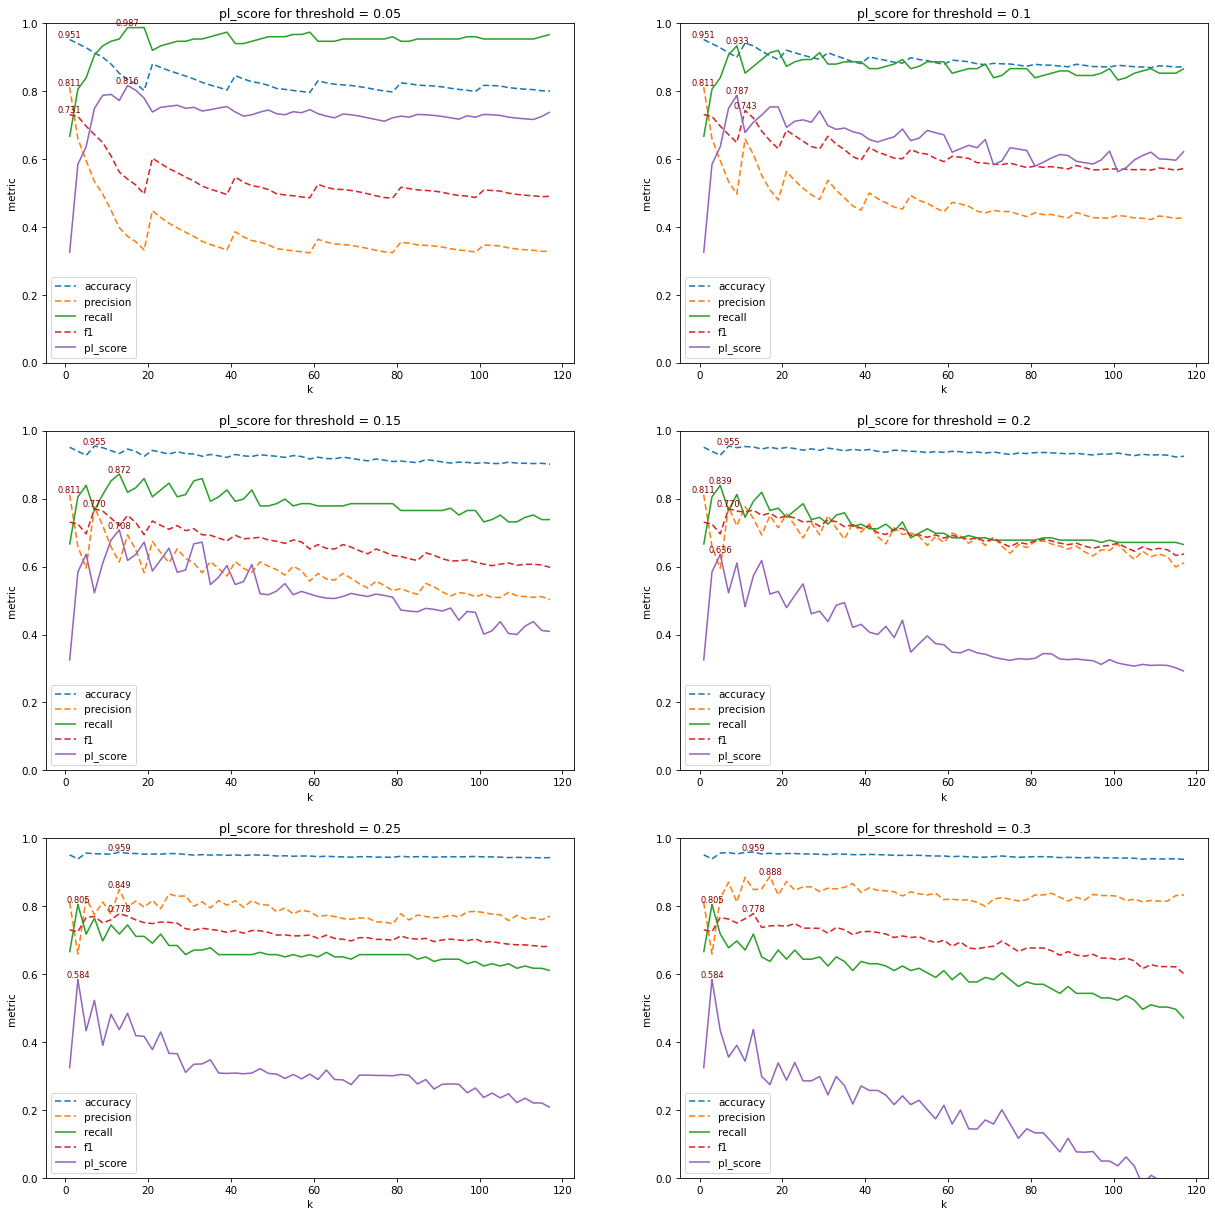

In [17]:
threshold_count = len(results_df.threshold.unique()) # number of thresholds found in the dataset

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), dpi=75)
for i, threshold in enumerate(results_df.threshold.unique()):
    
    row = i // 2
    col = i % 2 
    
    ax[row,col].set_ylim([0, 1])
    ax[row,col].set_xlabel("k")
    ax[row,col].set_ylabel("metric")

    results_for_threshold = results_df[results_df.threshold == threshold]
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'pl_score']:
        
        linestyle='--'
        if metric in ['pl_score', 'recall']:
            dashes=(4, 0)
        else:
            dashes=(4, 2)
        
        # add the line for this metric
        ax[row,col].plot(results_for_threshold.k, results_for_threshold[metric], markersize=2, label=metric, linestyle=linestyle, dashes=dashes)
        
        # add an annotation at the max point for this metric
        for x,y in zip(results_for_threshold.k,results_for_threshold[metric]):
            ax[row,col].set_title(f"{metric} for threshold = {threshold}")
            if max(results_for_threshold[metric]) == y:
                label = f"{y:.3f}"
                ax[row,col].annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,2), # distance from text to points (x,y)
                     ha='center',  # horizontal alignment can be left, right or center
                     size=8,
                     #weight='bold',
                     color='maroon')
                break # since we are only print the first max we find, exit the loop once one is found    
        
    handles, labels = ax[row,col].get_legend_handles_labels()
    ax[row,col].legend(handles, labels, fontsize=10)

plt.show()

## Summarize for models tested

Display the best results for each of the threshold values tested...

In [18]:
print(f"Max P&L expected from model with ...")


for threshold in np.round(np.arange(start, stop, step),3):
    best_result = results_df.loc[results_df[results_df.threshold == threshold]['model_profit'].idxmax()]
    print(f"  At threshold={best_result.threshold:.3f}: ${best_result.model_profit:,.2f} at k={best_result.k:02.0f}")



Max P&L expected from model with ...
  At threshold=0.050: $352,333.33 at k=15
  At threshold=0.100: $340,000.00 at k=09
  At threshold=0.150: $305,666.67 at k=13
  At threshold=0.200: $274,666.67 at k=05
  At threshold=0.250: $252,333.33 at k=03
  At threshold=0.300: $252,333.33 at k=03
